# Image Classification toward Behavioral Phase Identification in Drosophila

#### The goal of this project was to learn how to build a suite of tools for classifying microscopy data without requiring subjective, manual user annotations. My research is focused on identifying how neural circuits drive changes in muscle contractions to shift behaviors, and the data that I'd like to classify is a time series of muscle contractions. These data were collected on a fluorecence microscope and the sample is a fruit fly, Drosophila melanogaster, at the pupal stage of development undergoing the pupal ecdysis (molting) behavioral sequence. I am able to visualize the individual muscle fibers during contraction because the flies are expressing a genetically-encoded calcium biosensor called GCaMP6s, which shows a large change in fluorescence when the muscles contract. The pupal ecdysis sequence has four stereotyped behaviors and these are identifable by the pattern of muscle contractions that occur during each phase. Each phase is different from the others and easily classifiable to the human eye. The images were collected at a sampling rate of 2Hz over ~90 minutes, which makes each dataset more than 10,000 images. These data were far too large to perform the type of machine learning analysis that I'd like to perform without using a cluster (like Biowulf), which I am working toward being able to use. Below is a machine learning workflow that has been tested using the MNIST dataset and I hope will be scalable with a little more work to usable on my own images. At the bottom of the notebook are sample images of each phase of the ecdysis behavior. 

#### In summary, I have imported teh MNIST dataset, pre-processed it for machine learning by flattening the 3D array into a vector that can be read into the various ML algorithms. Using logistic regression a classifcation accuracy of 92% was achieved using the liblinear solver. I then scaled using the StandardScaler and MinMaxScaler. The MinMaxScaler was faster and performed better with a 92% accuracy over the 89% prodcued by the StandardScaler. The best results for logistic regression were achieved using the SVM algorithm with 94% accuracy. As expected reducing the dimensionality of the dataset with PCA is not very inspiring, but t-SNE is too time consuming to do on such large data so it isn't practical to test. Similarly, I left in the code for hyperparameter optimization using GridSearchCV to assist in a KNN classification model (which I tested with the even simpler digits dataset) but it took too long to run for me to report the results here. However, the CNN that I trained using Tensorflow and Keras produced a 99% accuracy, which I expect is the best that could be achieved. Next steps are to try to run this on Biowulf with my actual data and play around with the parameters to see how well it will do.

In [92]:
# Importing necessary modules and tools for this project

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import datasets
from keras.datasets import mnist
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from keras.utils import np_utils
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics
import sklearn.manifold
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.cluster
import sklearn.feature_selection
import sklearn.ensemble
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import tensorflow as tf
from keras import backend as K
import io
import glob2 as glob
import cv2 as cv


from sklearn.metrics import confusion_matrix

import warnings

warnings.filterwarnings(action='once')



In [54]:
# Loading the MNIST dataset and separating out to training and testing data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

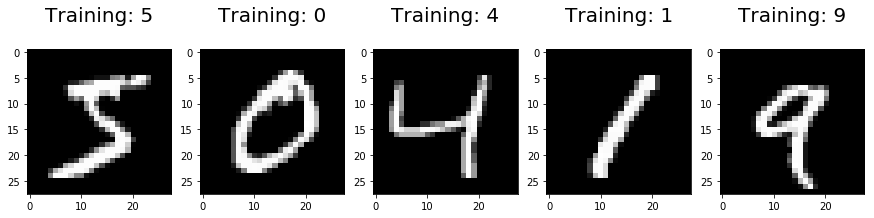

In [37]:
# Plot samples of the training data with labels

alist = X_train[0:5]
blist = y_train[0:5]
plt.figure(figsize=(15,4))
for index, (image, label) in enumerate(zip(alist, blist)):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [55]:
X_train.shape

(60000, 28, 28)

In [56]:
y_train.shape

(60000,)

In [46]:
# Building the input vector from the 28x28 pixels in the images

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalizing the data to the maximum pixel value
X_train /= 255
X_test /= 255

# Print the final pre-processed
print("Pre-processed training shape", X_train.shape)
print("Pre-processed testing shape", X_test.shape)

Pre-processed training shape (60000, 784)
Pre-processed testing shape (10000, 784)


In [9]:
'''
Logistic regression is a probabalistic linear classifer useful for situations where the 
dependent variable is categorical. In the case of the data I want to eventually use this on, 
the behavioral phases become classes, which are categorical, so I wanted to be able to start with this.

'''

# Note that lbfgs and newton-cg did not converge so liblinear is the solver of choice for this dataset

logReg = LogisticRegression(solver='liblinear', multi_class='auto')
result = logReg.fit(X_train, y_train)
predictions = logReg.predict(X_test)

In [10]:
# liblinear solver score

score = logReg.score(X_test, y_test)
print(score)

0.9201


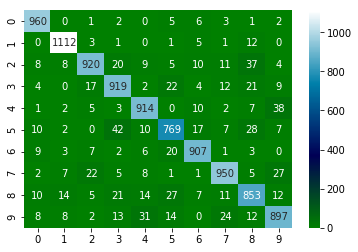

In [12]:
# Confusion matrix to show predictions 

cm = metrics.confusion_matrix(y_test, predictions)
sb.heatmap(cm, annot=True, fmt="d", cmap = "ocean")

In [15]:
# Getting the samples that did not match predictions correctly

index = 0
misclassifiedIndexes = []
for label, predict in zip(y_test, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

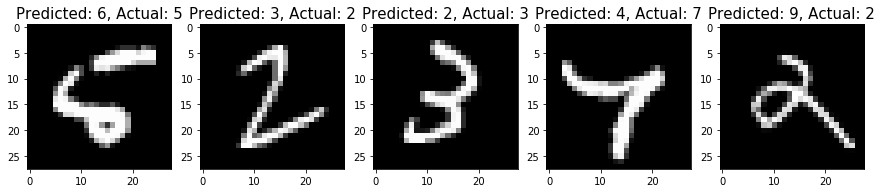

In [16]:
# Plotting mis-predicted samples

plt.figure(figsize=(15,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(X_test[badIndex], (28,28)), cmap=plt.cm.gray)
    plt.title("Predicted: {}, Actual: {}".format(predictions[badIndex], y_test[badIndex]), fontsize = 15)

In [5]:
# Scaling the data with StandardScaler() and MinMaxScaler() to test which performs best

scaler = StandardScaler()
mms = MinMaxScaler()

# Scale training data

scaler.fit(X_train)
mms.fit(X_train)

# Apply transform to both the training set and the test sets

X_trainsc = scaler.transform(X_train)
X_testsc = scaler.transform(X_test)

X_trainmms = mms.transform(X_train)
X_testmms = mms.transform(X_test)

In [6]:
# PCA to reduce dimensionality

pca = PCA(n_components=2)
pc = pca.fit_transform(X_trainmms)

In [7]:
# Fit the model

X_trainpca = pca.transform(X_trainmms)
X_testpca = pca.transform(X_testmms)

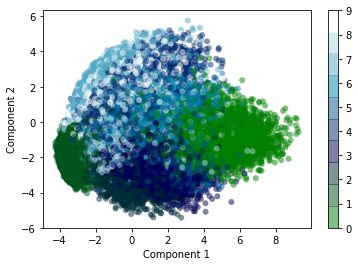

In [10]:
# Plot the principle components

plt.scatter(pc[:, 0], pc[:,1],
             c=y_train, edgecolor='none', alpha=0.5,
             cmap=plt.cm.get_cmap('ocean', 10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

In [43]:
# Logistic regression again on scaled data with Standard Scaler

logReg = LogisticRegression(solver='liblinear', multi_class='auto')
result = logReg.fit(X_trainsc, y_train)
predictions = logReg.predict(X_testsc)


In [44]:
# Logistic regression again on scaled data with MinMaxScaler

logReg = LogisticRegression(solver='liblinear', multi_class='auto')
result3 = logReg.fit(X_trainmms, y_train)
predictions3 = logReg.predict(X_testmms)

In [45]:
# Comparing scores between the two scaling methods

score2 = logReg.score(X_testsc, y_test)
print(score2)

score3 = logReg.score(X_testmms, y_test)
print(score3)

0.7955
0.92


In [48]:
# Using SVM to try and achieve better prediction scores

clf = svm.SVC(gamma='auto')
clf.fit(X_trainmms, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
# Getting the accuracy of the model

svmscore = clf.score(X_test,y_test)
print(svmscore)

0.9446


In [ ]:
# Using GridSearchCV for hyperparameter optimization in KNN

knn = KNeighborsClassifier()

# (Hyper)parameter grid
p_grid = {
    "n_neighbors": [3, 5, 7, 9]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
g = GridSearchCV(knn, p_grid, cv=cv)

g.fit(X_train, y_train)
best = g.best_params_
cv = g.cv_results_


print('GridSearch found optimal number of neighbors:', best['n_neighbors'])
print('Mean CV test scores are:', cv['mean_test_score'])

knn = KNeighborsClassifier(n_neighbors = best['n_neighbors']) 
knn.fit(X_train, y_train)

print('Accuracy:', accuracy_score(y_test, knn.predict(X_test)))

In [35]:
# One hot encoding the labels for input into keras

ohe = OneHotEncoder()
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
y_train = np_utils.to_categorical(y = y_train, num_classes = 10)
#y_test = np_utils.to_categorical(y = y_train, num_classes = 10)

#Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [62]:
# Preparing training data for recognition by keras

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [66]:
# Specifying the layers for a sequential model

model = Sequential()
model.add(Conv2D(32, kernel_size = (5,5), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
__________

In [79]:
# Compiling and fitting the model

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

tfresult = model.fit(X_train, y_train,
           batch_size=1000, epochs=8,
           verbose=2,
           validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
 - 63s - loss: 0.0381 - acc: 0.9881 - val_loss: 0.0308 - val_acc: 0.9901
Epoch 2/8
 - 56s - loss: 0.0317 - acc: 0.9900 - val_loss: 0.0261 - val_acc: 0.9913
Epoch 3/8
 - 1915s - loss: 0.0276 - acc: 0.9913 - val_loss: 0.0231 - val_acc: 0.9927
Epoch 4/8
 - 62s - loss: 0.0255 - acc: 0.9923 - val_loss: 0.0239 - val_acc: 0.9914
Epoch 5/8
 - 59s - loss: 0.0237 - acc: 0.9925 - val_loss: 0.0243 - val_acc: 0.9921
Epoch 6/8
 - 57s - loss: 0.0213 - acc: 0.9930 - val_loss: 0.0233 - val_acc: 0.9922
Epoch 7/8
 - 57s - loss: 0.0198 - acc: 0.9937 - val_loss: 0.0246 - val_acc: 0.9923
Epoch 8/8
 - 58s - loss: 0.0167 - acc: 0.9950 - val_loss: 0.0220 - val_acc: 0.9931


In [80]:
# Predictions using the model

tfpredictions = model.predict_classes(X_test)

In [81]:
# Evaluate the model

evaluate = model.evaluate(X_test, y_test)
print("Loss: {}".format(evaluate[0]))
print("Accuracy: {}".format(evaluate[1]))

10000/10000 [==============================] - 3s 337us/step
Loss: 0.021951282680941948
Accuracy: 0.9931


In [93]:
# Read in dataset of interest

path = glob.glob("/Users/ev/Desktop/17SeptHalf/*.tif")
cv_img1 = []
for img in path:
    n = cv.imread(img, cv.IMREAD_GRAYSCALE)
    cv_img1.append(n)

/anaconda3/lib/python3.6/site-packages/glob2/fnmatch.py:80: DeprecationWarning: Flags not at the start of the expression '(.*)\\.tif\\Z(?ms)'
  return re.compile(res, flags).match


In [95]:
# Cast the tiffs as arrays for use with sklearn

sept17 = np.asarray(cv_img1);
sept17.shape

(7053, 2102, 694)

In [100]:
# Load csv with labels

labels = pd.read_csv("labels.csv", index_col=False)
labels = labels.iloc[::2]

In [101]:
labels.shape

(7053, 3)

/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


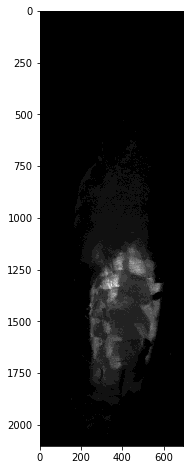

In [98]:
# Plot a random figure from the dataset of interest

plt.figure(1, figsize=(8,8))
plt.imshow(sept17[5000], cmap=plt.cm.gray, interpolation='nearest')
plt.show()